In [0]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torchvision import models

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

I'm creating train and test objects using torchvision transforms to do all the preprocessing. In the preprocessing first I'm reshaping images to 224x224x3 and then normalizing the three RGB channels to have mean and standard deviation of 0.5.

In [0]:
def prepare_train(size):

  transform_train = transforms.Compose([
      transforms.RandomResizedCrop(size), 
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
  
  train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
  return(train) 

def prepare_test(size):

  transform_test = transforms.Compose([
      transforms.RandomResizedCrop(224), 
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
  
  test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
  return(test) 

In [34]:
trainset = prepare_train(224)
testset = prepare_test(224)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [38]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
9


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

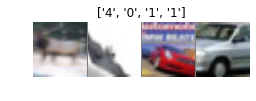

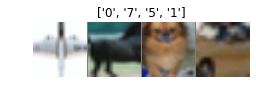

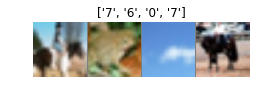

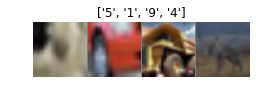

In [41]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [42]:
vgg = models.vgg16_bn()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [43]:
print(vgg.features[0])
print(vgg.classifier[6])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=4096, out_features=1000, bias=True)


To use VGG, first we need to modify the last layer so that instead of 1000 output we should get only 10 output.

In [44]:
final_in_features = vgg.classifier[6].in_features
#removing last layer
mod_classifier = list(vgg.classifier.children())[:-1]
#adding last layer which will have 10 classes
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=10, bias=True)]


In [45]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

### Train CIFAR10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.76
Iteration: 100/3125, Loss: 2.61
Iteration: 200/3125, Loss: 2.65
Iteration: 300/3125, Loss: 2.54
Iteration: 400/3125, Loss: 2.20
Iteration: 500/3125, Loss: 2.62
Iteration: 600/3125, Loss: 2.26
Iteration: 700/3125, Loss: 2.20
Iteration: 800/3125, Loss: 2.26
Iteration: 900/3125, Loss: 2.15
Iteration: 1000/3125, Loss: 3.08
Iteration: 1100/3125, Loss: 2.15
Iteration: 1200/3125, Loss: 2.51
Iteration: 1300/3125, Loss: 2.25
Iteration: 1400/3125, Loss: 2.10
Iteration: 1500/3125, Loss: 2.26
Iteration: 1600/3125, Loss: 2.43
Iteration: 1700/3125, Loss: 2.17
Iteration: 1800/3125, Loss: 2.24
Iteration: 1900/3125, Loss: 2.35
Iteration: 2000/3125, Loss: 2.25
Iteration: 2100/3125, Loss: 2.17
Iteration: 2200/3125, Loss: 2.07
Iteration: 2300/3125, Loss: 2.02
Iteration: 2400/3125, Loss: 1.99
Iteration: 2500/3125, Loss: 1.99
Iteration: 2600/3125, Loss: 2.10
Iteration: 2800/3125, Loss: 2.49
Iteration: 2900/3125, Loss: 1.99
Iteration: 3000/3125, Loss: 1.94
Iteration: 3100/3125, 

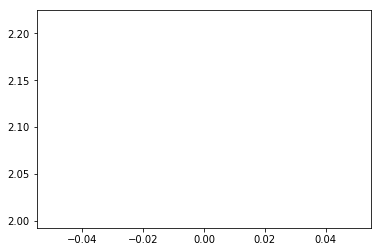

In [49]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

It's taking a lot of time to train vgg for a single epoch. Next I'm going to use pretrained weights of the model. 

### Freeze layers of Convolutional Operations

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
def change_output(mm):
  final_in_features = mm.classifier[len(mm.classifier)-1].in_features
  #redifing the output layer
  mm.classifier[len(mm.classifier)-1] = nn.Linear(final_in_features, num_classes)
  return mm 

In [0]:
vgg = change_output(vgg)

In [55]:
#checking which layers requires updates
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.36
Iteration: 100/3125, Loss: 1.85
Iteration: 200/3125, Loss: 1.60
Iteration: 300/3125, Loss: 2.54
Iteration: 400/3125, Loss: 3.23
Iteration: 500/3125, Loss: 2.21
Iteration: 600/3125, Loss: 1.89
Iteration: 700/3125, Loss: 1.17
Iteration: 800/3125, Loss: 2.64
Iteration: 900/3125, Loss: 2.20
Iteration: 1000/3125, Loss: 1.26
Iteration: 1100/3125, Loss: 1.90
Iteration: 1200/3125, Loss: 2.25
Iteration: 1300/3125, Loss: 1.68
Iteration: 1400/3125, Loss: 1.61
Iteration: 1500/3125, Loss: 1.08
Iteration: 1600/3125, Loss: 2.78
Iteration: 1700/3125, Loss: 1.55
Iteration: 1800/3125, Loss: 2.64
Iteration: 1900/3125, Loss: 1.29
Iteration: 2000/3125, Loss: 1.52
Iteration: 2100/3125, Loss: 2.25
Iteration: 2200/3125, Loss: 2.06
Iteration: 2300/3125, Loss: 2.57
Iteration: 2400/3125, Loss: 1.38
Iteration: 2500/3125, Loss: 2.70
Iteration: 2600/3125, Loss: 2.47
Iteration: 2700/3125, Loss: 1.31
Iteration: 2800/3125, Loss: 1.31
Iteration: 2900/3125, Loss: 1.87
Iteration: 3000/3125, 

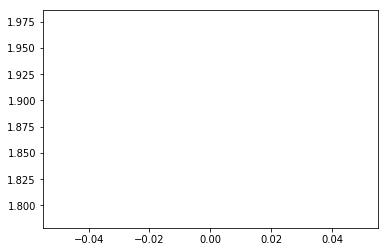

In [57]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

As we can see loss is sometimes increasing, sometimes decreasing. So we need to store our model asscociated with the best loss.

### With model copies

Storing best models identified during the training process.

In [0]:
def train(mm,loss_fn,opt):

  loss_epoch_arr = []
  max_epochs = 2

  min_loss = 1000

  n_iters = np.ceil(50000/batch_size)

  for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()

      outputs = mm(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()
        
      if min_loss > loss.item():
        min_loss = loss.item()
        best_model = copy.deepcopy(mm.state_dict())
        print('Min loss %0.2f' % min_loss)
        
      if i % 100 == 0:
        print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
      del inputs, labels, outputs
      torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
  return best_model

In [59]:
best_model = train(vgg,loss_fn,opt)
vgg.load_state_dict(best_model)

Min loss 1.61
Iteration: 0/3125, Loss: 1.61
Min loss 1.36
Min loss 1.25
Min loss 1.15
Min loss 0.74
Iteration: 100/3125, Loss: 1.84
Iteration: 200/3125, Loss: 1.81
Min loss 0.69
Iteration: 300/3125, Loss: 2.69
Iteration: 400/3125, Loss: 1.88
Iteration: 500/3125, Loss: 2.90
Iteration: 600/3125, Loss: 2.19
Iteration: 700/3125, Loss: 2.10
Iteration: 800/3125, Loss: 1.42
Min loss 0.64
Iteration: 900/3125, Loss: 3.00
Iteration: 1000/3125, Loss: 0.99
Iteration: 1100/3125, Loss: 1.86
Iteration: 1200/3125, Loss: 2.31
Min loss 0.42
Iteration: 1300/3125, Loss: 1.91
Iteration: 1400/3125, Loss: 2.31
Iteration: 1500/3125, Loss: 1.62
Iteration: 1600/3125, Loss: 2.11
Iteration: 1700/3125, Loss: 2.27
Iteration: 1800/3125, Loss: 1.45
Iteration: 1900/3125, Loss: 3.24
Iteration: 2000/3125, Loss: 3.20
Iteration: 2100/3125, Loss: 2.23
Iteration: 2200/3125, Loss: 2.09
Iteration: 2300/3125, Loss: 2.48
Iteration: 2400/3125, Loss: 2.86
Iteration: 2500/3125, Loss: 1.45
Iteration: 2600/3125, Loss: 2.32
Iteration

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [60]:
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

45.12 45.21


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

ResNet doesn't have vanishing gradient problem because it allows to move forward as well as backward as a result of identity connections. 

In [61]:
resnet = models.resnet18(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [62]:
for param in resnet.parameters():
    param.requires_grad = False
    
#again changing last output layer
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)


torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [64]:
best_model = train(resnet,loss_fn,opt)
resnet.load_state_dict(best_model)

Min loss 2.58
Iteration: 0/3125, Loss: 2.58
Min loss 2.39
Min loss 2.34
Min loss 2.16
Min loss 2.04
Min loss 2.00
Min loss 1.99
Min loss 1.68
Min loss 1.63
Min loss 1.57
Iteration: 100/3125, Loss: 1.76
Min loss 1.53
Min loss 1.48
Min loss 1.41
Min loss 1.32
Min loss 1.27
Iteration: 200/3125, Loss: 1.61
Min loss 1.24
Min loss 1.21
Min loss 0.99
Iteration: 300/3125, Loss: 1.24
Min loss 0.99
Iteration: 400/3125, Loss: 1.46
Min loss 0.90
Iteration: 500/3125, Loss: 1.53
Iteration: 600/3125, Loss: 1.46
Min loss 0.90
Min loss 0.85
Iteration: 700/3125, Loss: 1.15
Min loss 0.79
Iteration: 800/3125, Loss: 1.27
Min loss 0.74
Iteration: 900/3125, Loss: 1.20
Iteration: 1000/3125, Loss: 1.26
Iteration: 1100/3125, Loss: 1.08
Min loss 0.71
Iteration: 1200/3125, Loss: 1.09
Iteration: 1300/3125, Loss: 1.34
Min loss 0.63
Iteration: 1400/3125, Loss: 1.25
Iteration: 1500/3125, Loss: 1.32
Iteration: 1600/3125, Loss: 1.31
Iteration: 1700/3125, Loss: 1.34
Iteration: 1800/3125, Loss: 1.22
Iteration: 1900/3125,

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [65]:
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

55.824 55.04


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

Inception has auxillary output and is used in training time to make sure the gradients flow both way so that there is no vanishing of gradient. However it doen't play any role in the inference time.

In [66]:
inception = models.inception_v3(pretrained=True)
print(inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:03<00:00, 28862214.10it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In inception we need to unfreeze both output and auxillary output layer

In [67]:
for param in inception.parameters():
    param.requires_grad = False

aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [68]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [69]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.92
Iteration: 0/3125, Loss: 2.92
Min loss 2.80
Min loss 2.79
Min loss 2.77
Min loss 2.77
Min loss 2.71
Min loss 2.68
Min loss 2.66
Min loss 2.59
Min loss 2.43
Min loss 2.42
Iteration: 100/3125, Loss: 2.64
Min loss 2.39
Min loss 2.33
Min loss 2.20
Min loss 2.11
Min loss 2.00
Iteration: 200/3125, Loss: 2.50
Iteration: 300/3125, Loss: 2.39
Min loss 1.96
Min loss 1.91
Min loss 1.88
Min loss 1.85
Iteration: 400/3125, Loss: 2.65
Min loss 1.79
Min loss 1.78
Min loss 1.77
Min loss 1.76
Iteration: 500/3125, Loss: 2.18
Min loss 1.75
Min loss 1.69
Iteration: 600/3125, Loss: 1.92
Min loss 1.67
Min loss 1.64
Iteration: 700/3125, Loss: 2.07
Min loss 1.58
Min loss 1.53
Min loss 1.33
Iteration: 800/3125, Loss: 2.50
Iteration: 900/3125, Loss: 1.76
Iteration: 1000/3125, Loss: 2.14
Iteration: 1100/3125, Loss: 1.52
Min loss 1.21
Iteration: 1200/3125, Loss: 2.47
Iteration: 1300/3125, Loss: 2.01
Iteration: 1400/3125, Loss: 1.92
Iteration: 1500/3125, Loss: 2.27
Iteration: 1600/3125, Loss: 2.01
Ite

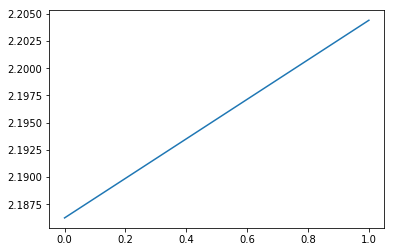

In [74]:
loss_epoch_arr = []
max_epochs = 2

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [75]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

48.662 47.98


# DenseNet



In [76]:
densenet = models.densenet161(pretrained=True)
print(densenet)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:03<00:00, 30080444.33it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [77]:
trainset = prepare_train(224)
testset = prepare_test(224)

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
for param in densenet.parameters():
    param.requires_grad = False

final_in_features = densenet.classifier.in_features
#removing last layer
mod_classifier = list(densenet.classifier.children())[:-1]
#adding last layer which will have 10 classes
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
densenet.classifier = nn.Sequential(*mod_classifier)

for param in densenet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 2208])
torch.Size([10])


In [0]:
densenet = densenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(densenet.parameters(), lr=0.05)

In [81]:
best_model = train(densenet,loss_fn,opt)

Min loss 2.39
Iteration: 0/3125, Loss: 2.39
Min loss 2.10
Min loss 2.09
Min loss 1.30
Min loss 1.23
Min loss 0.90
Iteration: 100/3125, Loss: 2.00
Min loss 0.82
Iteration: 200/3125, Loss: 2.41
Min loss 0.61
Iteration: 300/3125, Loss: 1.46
Iteration: 400/3125, Loss: 1.60
Iteration: 500/3125, Loss: 1.74
Iteration: 600/3125, Loss: 1.42
Min loss 0.59
Min loss 0.52
Min loss 0.51
Iteration: 700/3125, Loss: 3.21
Min loss 0.32
Iteration: 800/3125, Loss: 1.24
Iteration: 900/3125, Loss: 1.16
Iteration: 1000/3125, Loss: 0.94
Iteration: 1100/3125, Loss: 0.96
Iteration: 1200/3125, Loss: 1.87
Iteration: 1300/3125, Loss: 1.98
Iteration: 1400/3125, Loss: 1.39
Iteration: 1500/3125, Loss: 0.92
Iteration: 1600/3125, Loss: 1.34
Iteration: 1700/3125, Loss: 1.83
Iteration: 1800/3125, Loss: 0.80
Min loss 0.32
Iteration: 1900/3125, Loss: 1.30
Iteration: 2000/3125, Loss: 2.21
Iteration: 2100/3125, Loss: 1.64
Iteration: 2200/3125, Loss: 1.48
Min loss 0.22
Iteration: 2300/3125, Loss: 0.54
Iteration: 2400/3125, Lo

In [82]:
densenet.load_state_dict(best_model)
print(evaluation(trainloader, densenet), evaluation(testloader, densenet))

58.924 57.33
